## Very Short Term Price Forecasting - New England Dataset
- Very Short Term == next hour price
- For comparison to a research publication
- Main objective is to optimize method for forecasting short term prices i.e. Next Day Prices
- Error Metrics are Mean Absolute Error and Mean Absolute Percentage Error
- Use RVM and Stack it with other Models to improve Generalization Error

In [26]:
#import required libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from collections import Counter
from scipy import stats

#import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [27]:
#specify the columns to use
cols_use_load = ['Date', 'Hour', 'DA_DEMD', 'DryBulb', 'DewPnt', 'Day']
cols_use_price = ['Date', 'Hour', 'DA_DEMD', 'DryBulb', 'DewPnt', 'DA_LMP', 'Day', 'DA_EC', 'DA_CC', 'DA_MLC']

### Load Data

In [29]:
#2012-14 dataset
data1 = pd.read_csv('loadData1.csv', usecols=cols_use_price, skiprows=range(1415,1439))
data2 = pd.read_csv('loadData2.csv', usecols=cols_use_price)
data3 = pd.read_csv('loadData3.csv', usecols=cols_use_price)

### Feature Engineering

In [30]:
#functions for converting string to datetime objects

def convert_string_to_datetime(string):
    datetime_obj = datetime.strptime(string, "%d-%b-%y")
    return datetime_obj.date()

#format is different for 2012,2013,2014
def convert_string_to_datetime2(string):
    datetime_obj = datetime.strptime(string, "%m/%d/%Y")
    return datetime_obj.date()

#format is different for 2015
def convert_string_to_datetime3(string):
    datetime_obj = datetime.strptime(string, "%d/%m/%Y")
    return datetime_obj.date()

#format for natural Gas prices
def convert_string_to_datetime4(string):
    datetime_obj = datetime.strptime(string, "%Y-%m-%d")
    return datetime_obj.date()

In [31]:
#append year wise data together to one single file
tot_data = data1.append([data2], ignore_index=True)

In [32]:
tot_data['Date'] = tot_data['Date'].apply(convert_string_to_datetime2)
tot_data['Date'] = pd.to_datetime(tot_data['Date'])

In [33]:
#function to get day from date
def get_day_from_date(date_time_obj):
    return int(date_time_obj.date().day)

#function to get month from date
def get_month_from_date(date_time_obj):
    return int(date_time_obj.date().month)

In [34]:
tot_data['Day_Date'] = tot_data['Date'].apply(get_day_from_date)

In [35]:
tot_data.head()

Date  Hour  DA_DEMD  DA_LMP  DA_EC  DA_CC  DA_MLC  DryBulb  DewPnt  \
0 2012-01-01     1  10711.0   35.12  35.22    0.0   -0.10       35      33   
1 2012-01-01     2  10276.0   33.38  33.39    0.0   -0.01       35      33   
2 2012-01-01     3   9868.0   30.26  30.30    0.0   -0.04       36      33   
3 2012-01-01     4   9771.0   28.88  28.88    0.0    0.00       36      33   
4 2012-01-01     5   9884.0   20.23  20.21    0.0    0.02       36      33   

   Day  Day_Date  
0    1         1  
1    1         1  
2    1         1  
3    1         1  
4    1         1

#### Add Target Labels - Next Hour Data

In [36]:
tot_data_labels = list(tot_data['DA_LMP'][1:])
tot_data_labels.append(data3['DA_LMP'][0])

In [37]:
tot_data = tot_data.reset_index(drop=True)
print("Done")

Done


In [38]:
tot_data['TARGET_DA_LMP'] = tot_data_labels

#### Add previous day same hour price
This should be more useful for very short term than prev week

In [39]:
prev_day_da_lmp_targ = tot_data['DA_LMP'][1:-24]
prev_day_da_lmp_targ = prev_day_da_lmp_targ.reset_index(drop=True)

prev_day_da_demd_targ = tot_data['DA_DEMD'][1:-24]
prev_day_da_demd_targ = prev_day_da_demd_targ.reset_index(drop=True)

prev_day_dry_bulb_targ = tot_data['DryBulb'][1:-24]
prev_day_dry_bulb_targ = prev_day_dry_bulb_targ.reset_index(drop=True)

temp_df = pd.DataFrame({
    'prev_day_da_lmp': prev_day_da_lmp_targ,
    'prev_day_da_demd': prev_day_da_demd_targ,
    'prev_day_dry_bulb': prev_day_dry_bulb_targ,
    'actual_da_lmp': tot_data['DA_LMP'][0:-25],
    'actual_da_demd': tot_data['DA_DEMD'][0:-25],
    'actual_dry_bulb': tot_data['DryBulb'][0:-25]
})

temp_df['chg_in_da_demd'] = temp_df['actual_da_demd'] - temp_df['prev_day_da_demd']
temp_df['chg_in_dry_bulb'] = temp_df['actual_dry_bulb'] - temp_df['prev_day_dry_bulb']
temp_df['chg_in_da_lmp'] = temp_df['actual_da_lmp'] - temp_df['prev_day_da_lmp']

In [40]:
tot_data = tot_data[24:-1]
tot_data = tot_data.reset_index(drop=True)

In [41]:
tot_data = pd.merge(tot_data, temp_df[['prev_day_da_demd','prev_day_da_lmp', 'prev_day_dry_bulb',
                           'chg_in_da_demd', 'chg_in_da_lmp', 'chg_in_dry_bulb']], how='inner', 
                    left_index=True, right_index=True)
len(tot_data)

17495

#### Add Previous Week Next Hour Data
Maybe useful for short-term, not so much for very short term forecasting

#### Add daily means to the data

In [42]:
mean_values = tot_data.groupby('Date', as_index=False).mean()[['Date','DA_DEMD', 'DA_LMP', 'DryBulb', 'DewPnt']]
temp = pd.merge(tot_data, mean_values, how='inner', left_on='Date', right_on='Date', 
                suffixes=('_actual_value','_daily_mean'))
tot_data = temp

#### Add crude oil prices

In [2]:
crude_oil = pd.read_csv('CurdeOil.csv', delimiter='\t')
crude_oil = crude_oil[::-1]
crude_oil = crude_oil.reset_index(drop=True)
crude_oil = crude_oil[2:]
crude_oil = crude_oil.reset_index(drop=True)

def get_num_from_vol_str(string):
    match = re.search(r"(\d+)", string)
    if match!=None:
        return float(match.group(1))
    
crude_oil = crude_oil[['Date', 'Price', 'Vol.']]
crude_oil['Date'] = crude_oil['Date'].apply(convert_string_to_datetime)
crude_oil['Date'] = pd.to_datetime(crude_oil['Date'])

crude_oil['Crude_Oil_Price'] = crude_oil['Price']
crude_oil['Crude_Oil_Vol'] = crude_oil['Vol.']

crude_oil = crude_oil.drop('Price', axis=1)
crude_oil = crude_oil.drop('Vol.', axis=1)

temp = pd.merge(tot_data, crude_oil, how='outer', left_on='Date', right_on='Date', suffixes=('_X','_crude_oil'))
temp.reset_index(drop=True)
temp['Crude_Oil_Price'] = temp['Crude_Oil_Price'].fillna(method='bfill')
temp['Crude_Oil_Vol'] = temp['Crude_Oil_Vol'].fillna(method='bfill')
temp = temp[0:len(tot_data)]
tot_data = temp

tot_data['Crude_Oil_Vol'] = tot_data['Crude_Oil_Vol'].apply(get_num_from_vol_str)

'''
temp2 = pd.merge(test, crude_oil, how='outer', left_on='Date', right_on='Date', suffixes=('_X','_crude_oil'))
temp2.reset_index(drop=True)
temp2['Crude_Oil_Price'] = temp2['Crude_Oil_Price'].fillna(method='bfill')
temp2['Crude_Oil_Vol'] = temp2['Crude_Oil_Vol'].fillna(method='bfill')
test = temp2[0:4271]

test['Crude_Oil_Vol'] = test['Crude_Oil_Vol'].apply(get_num_from_vol_str)
'''

NameError: name 'pd' is not defined

### Split Data to Train and Test set

In [44]:
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler

In [45]:
X = tot_data

In [48]:
sns.distplot(X['TARGET_DA_LMP'])

In [47]:
for i in range(len(X['TARGET_DA_LMP'])):
    if(X['TARGET_DA_LMP'][i] < 1):
        X['TARGET_DA_LMP'][i] = (X['TARGET_DA_LMP'][i-1]+X['TARGET_DA_LMP'][i+1])/2

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
plt.plot(X['DA_LMP_actual_value'])
plt.xlabel("Time(Hours)", {'fontsize':30})
plt.ylabel("Electricity Price Values",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Electricity Prices Raw Data", {'fontsize':30})
plt.savefig("plot_electricity_prices.jpg", format='jpg', bbox_inches='tight', dpi=600)

- Split Method - **23 Days** as **Training Set** for each month and remaining as **Test Set**

In [51]:
#train1 = X.query('Day_Date <24 & Date < datetime(2013,1,1)')#[(X.Day_Date <24) and (X.Date > )]
#train2 = X.query('Day_Date <24 & Date > datetime(2013,2,1)')#X[X['Date'] >= datetime(2013,1,1)]
#test1 = X.query('Day_Date >24 & Date < datetime(2013,1,1)')
#test2 = X.query('Day_Date >24 & Date > datetime(2013,2,1) & Date < datetime(2013,12,1)')
#[X.Day_Date>=24 and X.Date >= datetime(2013,1,1)]

train = X[X.Day_Date<24]
test = X[X.Day_Date>=24]

#train1 = train.query('Day_Date < 2')
#train2 = train.query('Day_Date > 9 & Day_Date < 12')
#train3 = train.query('Day_Date > 18 & Day_Date < 22')
#train = train1.append(train2)
#train = train.append(train3)
#test = test1.append(test2)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(len(train))
print(len(test))

13224
4271


### Selecting Specific Columns and Feature Scaling

In [52]:
#conditions = [x for x in train.columns if 'Date' 
#              not in x and 'TARGET_DA_LMP' not in x]
#test_conditions = [x for x in train.columns if 'Date' 
#             not in x and 'TARGET_DA_LMP' not in x and 'DewPnt_daily_mean' not in x 
#             and 'DryBulb_daily_mean' not in x and 'Prev_Week_DA_DEMD' not in x 
#                and 'DA_DEMD_daily_mean' not in x and 'DA_LMP_daily_mean' not in x 
#               ]

cond_to_use = ['DA_LMP_actual_value', 'chg_in_da_demd', 'chg_in_da_lmp', 'prev_day_da_lmp', 'DA_LMP_daily_mean',
              'Hour', 'DA_DEMD_actual_value', 'DryBulb_actual_value', 'DryBulb_daily_mean', 
               'Crude_Oil_Price']

train_x = train[cond_to_use]
train_y = pd.DataFrame(train['TARGET_DA_LMP'])
test_x = test[cond_to_use]
test_y = pd.DataFrame(test['TARGET_DA_LMP'])

In [53]:
std_scaler = StandardScaler()
train_x_scaled = std_scaler.fit_transform(train_x)
test_x_scaled = std_scaler.fit_transform(test_x)
train_y_scaled = std_scaler.fit_transform(train_y)

### MAPE Function and Other Error Metrics

In [54]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#function to calculate mape
def mean_absolute_percentage_error(y_pred, y_true): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def point_absolute_percentage_error(y_pred, y_true):
    return np.abs((y_true - y_pred) / y_true) * 100

#GIVE Everything you can imagine of function - SD, VAR, MIN and MAX ERROR, CI
def get_CI_VAR_SD(error_list):
    t = stats.t.ppf(1-0.025, len(error_list)-1)
    max_err = np.mean(error_list) + (t * (np.std(error_list)/np.sqrt(len(error_list))))
    min_err = np.mean(error_list) - (t * (np.std(error_list)/np.sqrt(len(error_list))))
    ci = ((max_err - np.mean(error_list))/np.mean(error_list))*100
    sd = np.std(error_list)
    var = np.var(error_list)
    return (max_err, min_err, ci, sd, var)

### PRICE PREDICTIONS

In [55]:
#import all models required from scikit learn

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from skbayes.rvm_ard_models import RVR


from sklearn.grid_search import GridSearchCV

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [57]:
import timeit

### Function to save model to disk

In [56]:
import pickle

def save_model(model_obj, filename):
    try:
        with open(filename, 'wb') as fid:
            pickle.dump(model_obj, fid) 
        print("Done")
    except Exception as e: print(e)

### Random Forest

In [58]:
params = {
    'max_depth': [13, 10, 7], #np.linspace(50,100,5, dtype=int),
    'n_estimators': [1000, 700], #np.linspace(500,2000,5, dtype=int)
    'bootstrap': [True]
}

#rf_reg_price = GridSearchCV(RandomForestRegressor(), params, n_jobs=-1, cv=7, scoring='neg_mean_squared_error')
rf_reg_price = RandomForestRegressor(max_depth=8, n_estimators=700, bootstrap=True)

start = timeit.default_timer()

rf_reg_price = rf_reg_price.fit(train_x_scaled, train_y_scaled)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)


try:
    print(rf_reg_price.best_params_)
    print("\n")
    print(rf_reg_price.best_score_)
except:
    print("Did Not Use GridSearch")

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Time:  35.80908468800044
Did Not Use GridSearch


#### Training Error and Test Error- MAPE

In [437]:
#train mape
rf_preds_price_train = rf_reg_price.predict(train_x_scaled)
rf_preds_price_train = std_scaler.inverse_transform(rf_preds_price_train)
err = mean_absolute_percentage_error(rf_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
rf_preds_price = rf_reg_price.predict(test_x_scaled)
rf_preds_price = std_scaler.inverse_transform(rf_preds_price)
err = mean_absolute_percentage_error(rf_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_rf = point_absolute_percentage_error(rf_preds_price, test_y['TARGET_DA_LMP'])
max_err_rf, min_err_rf, ci_rf, sd_rf, var_rf = get_CI_VAR_SD(point_err_rf)
print(max_err_rf, min_err_rf, ci_rf, sd_rf, var_rf)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list_rf =[]
mae_list_rf =[]
rmse_list_rf =[]
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(days_list[i], np.sum(days_list[:i+2])*24)
    temp_list_rf.append(mean_absolute_percentage_error(
        rf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list_rf.append(mean_absolute_error(
        rf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list_rf.append(np.sqrt(mean_squared_error(
        rf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list_rf

Train:  5.5093911993203095
Test:  6.422297407689223
6.61640613547 6.22818867991 3.02241885509 6.470511849283259 41.867523591715056


[4.867513569213462,
 5.771442774248204,
 7.01319570641966,
 7.512205634190626,
 6.238971062985879,
 7.227582746705553,
 5.6032697813438,
 6.344201329014236,
 5.215585248128309,
 5.376174155225968,
 7.106810179170926,
 8.070921777278238,
 10.054709814203854,
 7.128182718793536,
 6.98773283500643,
 5.588246539066567,
 5.332719422066445,
 5.867913414971737,
 4.41685557985556,
 5.529240056044768,
 5.20582101063229,
 4.759055538026985,
 7.693063898826146,
 9.264016292710993]

In [161]:
save_model(rf_reg_price, 'model_rf.pkl')

Done


#### RF Feature Importance Plot

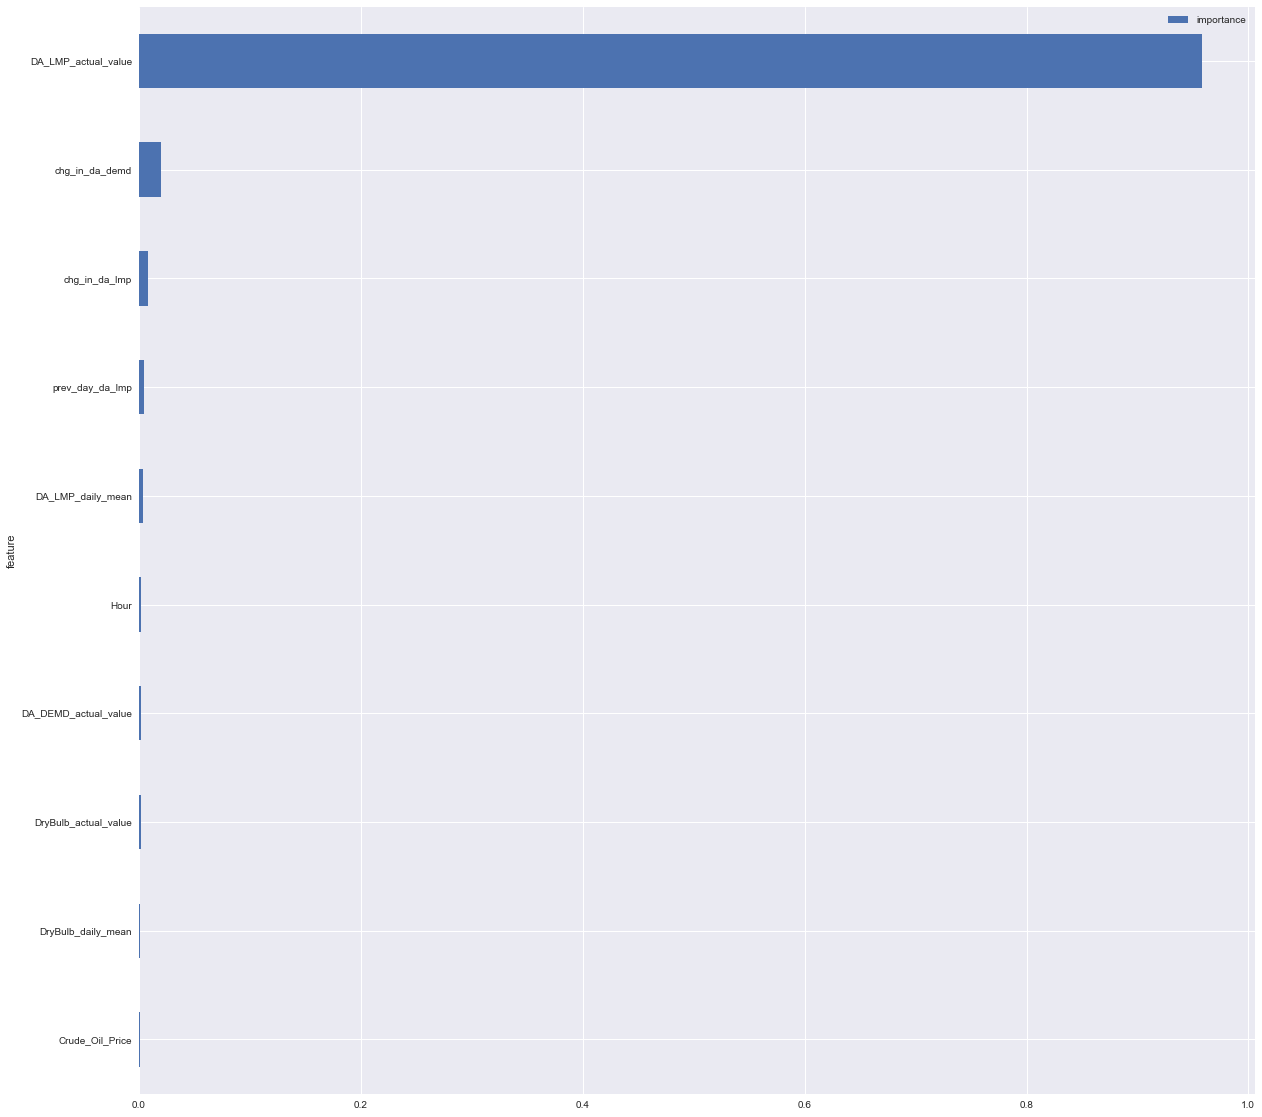

In [162]:
features = pd.DataFrame()
features['feature'] = train_x.columns
features['importance'] = rf_reg_price.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(20, 20))

# Level 1 Learning

### Adaboosted RVM
Make RVM as weak learner and then train many weak learners and apply ada boost to give weights

###### Algorithm worked well but not like what was expected
Improvements of upto 4-5% in MAPE from base classifiers but peaked around 8% MAPE and no further improvements

### eXtreme Gradient Boosting XGBoost

In [62]:
params = {
    'max_depth': [7],
    'min_child_weight':[14],
    'n_estimators': [800],
    'learning_rate':[0.01],
    'reg_lambda':[3],
    'gamma': [0.01],
    'reg_alpha':[1e-5]
}

#xgb_reg_price = GridSearchCV(XGBRegressor(silent=0), params, n_jobs=-1, cv=10, 
                       #scoring='neg_mean_squared_error') 
xgb_reg_price = XGBRegressor(silent=0, max_depth=7, min_child_weight=14, n_estimators=800, learning_rate=0.01,
                            reg_lambda=3, gamma=0.01, reg_alpha=1e-5)

start = timeit.default_timer()

xgb_reg_price.fit(train_x_scaled, train_y_scaled)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)

try:
    print(xgb_reg_price.best_params_)
    print("\n")
    print(xgb_reg_price.best_score_)
except:
    print("Did Not Use GridSearch")

Time:  11.56718250799895
Did Not Use GridSearch


In [69]:
#train mape
xgb_reg_preds_price_train = xgb_reg_price.predict(train_x_scaled)
xgb_reg_preds_price_train = std_scaler.inverse_transform(xgb_reg_preds_price_train)
err = mean_absolute_percentage_error(xgb_reg_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
xgb_reg_preds_price = xgb_reg_price.predict(test_x_scaled)
xgb_reg_preds_price = std_scaler.inverse_transform(xgb_reg_preds_price)
err = mean_absolute_percentage_error(xgb_reg_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_xgb = point_absolute_percentage_error(xgb_reg_preds_price, test_y['TARGET_DA_LMP'])
max_err_xgb, min_err_xgb, ci_xgb, sd_xgb, var_xgb = get_CI_VAR_SD(point_err_xgb)
print(max_err_xgb, min_err_xgb, ci_xgb, sd_xgb, var_xgb)

Train:  4.863842159837237
Test:  6.02499238693311
6.20926023165 5.84072454221 3.05839132875 6.142471213628366 37.729952610253136


In [347]:
days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list1 =[]
mae_list1 = []
rmse_list1 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list1.append(mean_absolute_percentage_error(
        xgb_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list1.append(mean_absolute_error(
        xgb_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list1.append(np.sqrt(mean_squared_error(
        xgb_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
np.mean(temp_list1)

6.022648315679743

In [218]:
save_model(xgb_reg_price, 'model_xgb.pkl')

Done


### RVM - RBF Kernel

In [63]:
rvm_rbf_price = RVR(kernel='rbf', gamma=0.001, verbose=1, n_iter=600)

start = timeit.default_timer()

rvm_rbf_price = rvm_rbf_price.fit(train_x_scaled, train_y_scaled)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of features in the model: 9
Iteration: 9, number of features in the model: 10
Iteration: 10, number of features in the model: 11
Iteration: 11, number of features in the model: 12
Iteration: 12, number of features in the model: 13
Iteration: 13, number of features in the model: 14
Iteration: 14, number of features in the model: 15
Iteration: 15, number of features in the model: 16
Iteration: 16, number of features in the model: 17
Iteration: 17, number of features in the model: 18
Iteration: 18, number of features in the model: 19
Iteration: 19, number of features in the model: 19

Iteration: 161, number of features in the model: 101
Iteration: 162, number of features in the model: 102
Iteration: 163, number of features in the model: 101
Iteration: 164, number of features in the model: 101
Iteration: 165, number of features in the model: 102
Iteration: 166, number of features in the model: 102
Iteration: 167, number of features in the model: 102
Iteration: 168, number of features in the model: 103
Iteration: 169, number of features in the model: 103
Iteration: 170, number of features in the model: 103
Iteration: 171, number of features in the model: 103
Iteration: 172, number of features in the model: 104
Iteration: 173, number of features in the model: 105
Iteration: 174, number of features in the model: 106
Iteration: 175, number of features in the model: 106
Iteration: 176, number of features in the model: 107
Iteration: 177, number of features in the model: 106
Iteration: 178, number of features in the model: 105
Iteration: 179, number of features in the mode

Iteration: 318, number of features in the model: 84
Iteration: 319, number of features in the model: 84
Iteration: 320, number of features in the model: 84
Iteration: 321, number of features in the model: 83
Iteration: 322, number of features in the model: 83
Iteration: 323, number of features in the model: 83
Iteration: 324, number of features in the model: 83
Iteration: 325, number of features in the model: 82
Iteration: 326, number of features in the model: 82
Iteration: 327, number of features in the model: 83
Iteration: 328, number of features in the model: 83
Iteration: 329, number of features in the model: 83
Iteration: 330, number of features in the model: 83
Iteration: 331, number of features in the model: 83
Iteration: 332, number of features in the model: 83
Iteration: 333, number of features in the model: 83
Iteration: 334, number of features in the model: 84
Iteration: 335, number of features in the model: 84
Iteration: 336, number of features in the model: 84
Iteration: 3

Iteration: 475, number of features in the model: 103
Iteration: 476, number of features in the model: 103
Iteration: 477, number of features in the model: 102
Iteration: 478, number of features in the model: 101
Iteration: 479, number of features in the model: 100
Iteration: 480, number of features in the model: 100
Iteration: 481, number of features in the model: 99
Iteration: 482, number of features in the model: 99
Iteration: 483, number of features in the model: 99
Iteration: 484, number of features in the model: 98
Iteration: 485, number of features in the model: 99
Iteration: 486, number of features in the model: 98
Iteration: 487, number of features in the model: 97
Iteration: 488, number of features in the model: 97
Iteration: 489, number of features in the model: 97
Iteration: 490, number of features in the model: 97
Iteration: 491, number of features in the model: 97
Iteration: 492, number of features in the model: 97
Iteration: 493, number of features in the model: 97
Iterat

In [85]:
#train mape
rvm_rbf_preds_price_train = rvm_rbf_price.predict(train_x_scaled)
rvm_rbf_preds_price_train = std_scaler.inverse_transform(rvm_rbf_preds_price_train)
err = mean_absolute_percentage_error(rvm_rbf_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
rvm_rbf_preds_price = rvm_rbf_price.predict(test_x_scaled)
rvm_rbf_preds_price = std_scaler.inverse_transform(rvm_rbf_preds_price)
err = mean_absolute_percentage_error(rvm_rbf_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)


point_err_rvm_rbf = point_absolute_percentage_error(rvm_rbf_preds_price, test_y['TARGET_DA_LMP'])
max_err_rvm_rbf, min_err_rvm_rbf, ci_rvm_rbf, sd_rvm_rbf, var_rvm_rbf = get_CI_VAR_SD(point_err_rvm_rbf)
print(max_err_rvm_rbf, min_err_rvm_rbf, ci_rvm_rbf, sd_rvm_rbf, var_rvm_rbf)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list2 =[]
mae_list2 = []
rmse_list2 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list2.append(mean_absolute_percentage_error(
        rvm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list2.append(mean_absolute_error(
        rvm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list2.append(np.sqrt(mean_squared_error(
        rvm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list2

Train:  5.925666119066655
Test:  6.06979472232715
6.24995916535 5.8896302793 2.96821311541 6.005686486925018 36.068270179233764


[5.1467972807237405,
 5.638769405040063,
 6.824446711206139,
 6.602746003829527,
 5.496309731868498,
 7.187631898356416,
 4.699002498757212,
 5.711608026648058,
 4.721738480799651,
 4.9554448902400825,
 6.9425344629911745,
 7.404654958683156,
 9.739492205005053,
 6.483449044895565,
 6.514129975258647,
 4.935239998927568,
 5.053969890337771,
 6.141387553218578,
 4.590137563225306,
 5.07409199877364,
 4.586326059265818,
 4.712096386284023,
 8.016772177997925,
 8.574831433800226]

In [178]:
save_model(rvm_rbf_price, 'model_rvm-rbf.pkl')

Done


### RVM - polynomial kernel

In [91]:
rvm_pol_price = RVR(kernel='poly', degree=3, coef0=0.08, gamma=0.05, verbose=1, n_iter=300)

start = timeit.default_timer()

rvm_pol_price = rvm_pol_price.fit(train_x_scaled, train_y_scaled)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of features in the model: 10
Iteration: 9, number of features in the model: 11
Iteration: 10, number of features in the model: 12
Iteration: 11, number of features in the model: 13
Iteration: 12, number of features in the model: 14
Iteration: 13, number of features in the model: 15
Iteration: 14, number of features in the model: 16
Iteration: 15, number of features in the model: 17
Iteration: 16, number of features in the model: 18
Iteration: 17, number of features in the model: 19
Iteration: 18, number of features in the model: 20
Iteration: 19, number of features in the model: 2

Iteration: 160, number of features in the model: 131
Iteration: 161, number of features in the model: 132
Iteration: 162, number of features in the model: 133
Iteration: 163, number of features in the model: 134
Iteration: 164, number of features in the model: 134
Iteration: 165, number of features in the model: 134
Iteration: 166, number of features in the model: 134
Iteration: 167, number of features in the model: 135
Iteration: 168, number of features in the model: 136
Iteration: 169, number of features in the model: 136
Iteration: 170, number of features in the model: 137
Iteration: 171, number of features in the model: 138
Iteration: 172, number of features in the model: 138
Iteration: 173, number of features in the model: 138
Iteration: 174, number of features in the model: 137
Iteration: 175, number of features in the model: 137
Iteration: 176, number of features in the model: 138
Iteration: 177, number of features in the model: 138
Iteration: 178, number of features in the mode

In [92]:
#train mape
rvm_pol_preds_price_train = rvm_pol_price.predict(train_x_scaled)
rvm_pol_preds_price_train = std_scaler.inverse_transform(rvm_pol_preds_price_train)
err = mean_absolute_percentage_error(rvm_pol_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
rvm_pol_preds_price = rvm_pol_price.predict(test_x_scaled)
rvm_pol_preds_price = std_scaler.inverse_transform(rvm_pol_preds_price)
err = mean_absolute_percentage_error(rvm_pol_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

Train:  5.820562815790225
Test:  6.0954830041521895


In [88]:
days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list3 =[]
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list3.append(mean_absolute_percentage_error(
        rvm_pol_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
temp_list3

[4.409881018530851,
 5.378959965271689,
 7.123874229265706,
 7.207874639518963,
 6.163765189774506,
 7.308070130586956,
 5.131255174013435,
 6.0380382791712455,
 4.243229590394089,
 5.153145111967251,
 6.785857589116858,
 7.489883675923384,
 9.071797178176142,
 6.159420365846255,
 6.4836702678820135,
 4.909353382939218,
 5.700134742025315,
 6.299053055625574,
 4.441104338227874,
 5.125362766306097,
 4.637943902537825,
 4.365084539875577,
 7.8383263831480825,
 8.52220876844048]

In [188]:
save_model(rvm_pol_price, 'model_rvm-poly.pk')

Done


### Kernel Ridge Regression
- Noresult after running for more than half hour

### ANN - MLP for comparison

In [105]:
params = {
    'hidden_layer_sizes': [(20,10,5)],
    'activation': ['relu'],
    'solver': ['lbfgs'],
    'max_iter': [1000], #np.linspace(40,100,60, dtype=int)
    'alpha': [0.0001],
}

mlp_reg_price = GridSearchCV(MLPRegressor(learning_rate='adaptive', verbose=1), params, cv=7, n_jobs=-1)
#mlp_reg_price = MLPRegressor(hidden_layer_sizes=(20,10,5), activation='relu', verbose=1, max_iter=5000, solver='lbfgs', 
                      #alpha=0.0001)

start = timeit.default_timer()

mlp_reg_price.fit(train_x_scaled, train_y_scaled)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)

try:
    print(mlp_reg_price.best_params_)
    print("\n")
    print(mlp_reg_price.best_score_)
except:
    print("Did Not Use GridSearch")

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/neural_network/mult

Time:  41.3495534270005
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 10, 5), 'max_iter': 1000, 'solver': 'lbfgs'}


0.9328031796369963


In [70]:
#train mape
mlp_reg_preds_price_train = mlp_reg_price.predict(train_x_scaled)
mlp_reg_preds_price_train = std_scaler.inverse_transform(mlp_reg_preds_price_train)
err = mean_absolute_percentage_error(mlp_reg_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
mlp_reg_preds_price = mlp_reg_price.predict(test_x_scaled)
mlp_reg_preds_price = std_scaler.inverse_transform(mlp_reg_preds_price)
err = mean_absolute_percentage_error(mlp_reg_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)


point_err_mlp = point_absolute_percentage_error(mlp_reg_preds_price, test_y['TARGET_DA_LMP'])
max_err_mlp, min_err_mlp, ci_mlp, sd_mlp, var_mlp = get_CI_VAR_SD(point_err_mlp)
print(max_err_mlp, min_err_mlp, ci_mlp, sd_mlp, var_mlp)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list4 =[]
mae_list4 = []
rmse_list4 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list4.append(mean_absolute_percentage_error(
        mlp_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list4.append(mean_absolute_error(
        mlp_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list4.append(np.sqrt(mean_squared_error(
        mlp_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list4

Train:  5.792546238552409
Test:  6.265543508509026
6.45264498908 6.07844202794 2.98619713223 6.236928967024149 38.89928293970492


[4.893469003528935,
 5.322333429101992,
 7.267463996290807,
 7.217586122848292,
 5.730785127701753,
 7.486306880388904,
 5.096216309966606,
 5.804956644688064,
 4.773978312521793,
 5.069378566506142,
 6.699129718351411,
 7.59044949333429,
 11.805704862186223,
 6.390584622756418,
 6.497213836111277,
 4.776027281711031,
 5.3477358391348355,
 6.797004632449462,
 4.794729673624077,
 5.407257403656533,
 4.796799534253978,
 4.396200345417942,
 7.8922870667262295,
 8.262378757761539]

### SVM

In [95]:
params = {
        'C': [3],
}

svm_price = GridSearchCV(SVR(), params, cv=7)

start = timeit.default_timer()

svm_price.fit(train_x_scaled, train_y_scaled)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when 

Time:  26.50052221900114


In [94]:
#train mape
svm_rbf_preds_price_train = svm_price.predict(train_x_scaled)
svm_rbf_preds_price_train = std_scaler.inverse_transform(svm_rbf_preds_price_train)
err = mean_absolute_percentage_error(svm_rbf_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
svm_rbf_preds_price = svm_price.predict(test_x_scaled)
svm_rbf_preds_price = std_scaler.inverse_transform(svm_rbf_preds_price)
err = mean_absolute_percentage_error(svm_rbf_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)


point_err_svm = point_absolute_percentage_error(svm_rbf_preds_price, test_y['TARGET_DA_LMP'])
max_err_svm, min_err_svm, ci_svm, sd_svm, var_svm = get_CI_VAR_SD(point_err_svm)
print(max_err_svm, min_err_svm, ci_svm, sd_svm, var_svm)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list5 =[]
mae_list5 = []
rmse_list5 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list5.append(mean_absolute_percentage_error(
        svm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list5.append(mean_absolute_error(
        svm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list5.append(np.sqrt(mean_squared_error(
        svm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list5

Train:  13.427130677988716
Test:  14.864822620193438
15.3229192876 14.4067259528 3.08174997485 15.27041029102895 233.18543045636287


[9.219377331751295,
 47.422377018523676,
 37.23025173593374,
 24.207860462080063,
 15.222972504655145,
 17.360578107438513,
 14.476925900858653,
 13.169372730767028,
 14.255774145012209,
 16.700872092642335,
 8.309784486969104,
 9.213289759317277,
 14.362799957116259,
 9.222775408906628,
 11.135366257709885,
 9.872354387396125,
 11.65154856924272,
 11.075243095316278,
 10.54594082518525,
 13.767528307895835,
 16.211474887183773,
 10.918292649953386,
 9.640234416016336,
 10.635877665171984]

In [193]:
save_model(svm_price, 'model_svm-rbf.pk')

Done


### Lasso

In [194]:
from sklearn.linear_model import Lasso

lasso_price = Lasso(alpha=0.001)
lasso_price = lasso_price.fit(train_x_scaled, train_y_scaled)

In [96]:
#train mape
lasso_preds_price_train = lasso_price.predict(train_x_scaled)
lasso_preds_price_train = std_scaler.inverse_transform(lasso_preds_price_train)
err = mean_absolute_percentage_error(lasso_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
lasso_preds_price = lasso_price.predict(test_x_scaled)
lasso_preds_price = std_scaler.inverse_transform(lasso_preds_price)
err = mean_absolute_percentage_error(lasso_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_lasso = point_absolute_percentage_error(lasso_preds_price, test_y['TARGET_DA_LMP'])
max_err_lasso, min_err_lasso, ci_lasso, sd_lasso, var_lasso = get_CI_VAR_SD(point_err_lasso)
print(max_err_lasso, min_err_lasso, ci_lasso, sd_lasso, var_lasso)


days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list6 =[]
mae_list6 = []
rmse_list6 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list6.append(mean_absolute_percentage_error(
        lasso_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list6.append(mean_absolute_error(
        lasso_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list6.append(np.sqrt(mean_squared_error(
        lasso_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list6

NameError: name 'lasso_price' is not defined

In [196]:
save_model(lasso_price, 'model_lasso.pk')

Done


### RNN

In [73]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

Using TensorFlow backend.


In [74]:
train_x_scaled[:, None].shape

rnn_train_x = train_x_scaled[:, None]
rnn_test_x = test_x_scaled[:, None]

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [75]:
rnn_train_x.shape

(13224, 1, 10)

In [80]:
K.clear_session()
model = Sequential()

model.add(LSTM(15, input_shape=(1, 10), activation='relu', return_sequences=True))
model.add(LSTM(15, activation='relu', return_sequences=True))
model.add(LSTM(15, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam')

start = timeit.default_timer()

model.fit(rnn_train_x, train_y_scaled,
          epochs=30, batch_size=20, verbose=1,
         callbacks=[early_stop], validation_split=0.1)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)
#number of iters is approx 3000 - each epoch has number of (datapoints/batch_size)*2 iterations

Train on 11901 samples, validate on 1323 samples
Epoch 1/30
11901/11901 [==============================] - 12s - loss: 0.2277 - val_loss: 0.1804
Epoch 2/30
11901/11901 [==============================] - 12s - loss: 0.1035 - val_loss: 0.1635
Epoch 3/30
11901/11901 [==============================] - 11s - loss: 0.0898 - val_loss: 0.1296
Epoch 4/30
11901/11901 [==============================] - 10s - loss: 0.0835 - val_loss: 0.1433
Epoch 5/30
11901/11901 [==============================] - 11s - loss: 0.0810 - val_loss: 0.1301
Epoch 6/30
11901/11901 [==============================] - 11s - loss: 0.0799 - val_loss: 0.1226
Epoch 7/30
11901/11901 [==============================] - 11s - loss: 0.0799 - val_loss: 0.1664
Epoch 8/30
11901/11901 [==============================] - 11s - loss: 0.0782 - val_loss: 0.1230
Epoch 9/30
11901/11901 [==============================] - 11s - loss: 0.0778 - val_loss: 0.1243
Epoch 10/30
11901/11901 [==============================] - 11s - loss: 0.0770 - val_los

In [81]:
#train mape
rnn_preds_price_train = model.predict(rnn_train_x)
rnn_preds_price_train = rnn_preds_price_train.flatten()
rnn_preds_price_train = std_scaler.inverse_transform(rnn_preds_price_train)
err = mean_absolute_percentage_error(rnn_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
rnn_preds_price = model.predict(rnn_test_x)
rnn_preds_price = rnn_preds_price.flatten()
rnn_preds_price = std_scaler.inverse_transform(rnn_preds_price)
err = mean_absolute_percentage_error(rnn_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_rnn = point_absolute_percentage_error(rnn_preds_price, test_y['TARGET_DA_LMP'])
max_err_rnn, min_err_rnn, ci_rnn, sd_rnn, var_rnn = get_CI_VAR_SD(point_err_rnn)
print(max_err_rnn, min_err_rnn, ci_rnn, sd_rnn, var_rnn)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list7 =[]
mae_list7 = []
rmse_list7 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list7.append(mean_absolute_percentage_error(
        rnn_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list7.append(mean_absolute_error(
        rnn_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list7.append(np.sqrt(mean_squared_error(
        rnn_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list7

Train:  5.553890139728688
Test:  6.334438318446026
6.52079745054 6.14807918635 2.94199931751 6.212183173044607 38.59121977545856


[4.677978379927292,
 5.784246083762514,
 7.936222914373301,
 6.9715741450712505,
 6.089866366263156,
 7.355465608785964,
 5.378703545111298,
 5.809160185699291,
 4.663829102571651,
 4.958017135849933,
 7.434492793008847,
 7.601230947844244,
 11.144186461269712,
 6.714259820523891,
 6.415051640394663,
 5.033776163165152,
 5.160379402098257,
 6.133823925264811,
 4.588549360332842,
 5.2478198521735635,
 4.7540763288188765,
 4.4058132893227935,
 8.2431976218998,
 9.466563840833905]

# Level 2 Learning

In [214]:
days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    print(np.sum(days_list[:i+1])*24)    

0
192
312
504
672
864
1032
1224
1416
1584
1776
1944
2136
2328
2448
2640
2808
3000
3168
3360
3552
3720
3912
4080


#### Create stacked train and test datasets

In [97]:
stacked_train = pd.DataFrame({
    'xgb': xgb_reg_preds_price_train,
    'rvm_rbf': rvm_rbf_preds_price_train,
    'rvm_pol': rvm_pol_preds_price_train,
    #'rnn': rnn_preds_price_train
})

stacked_test = pd.DataFrame({
    'xgb': xgb_reg_preds_price,
    'rvm_rbf': rvm_rbf_preds_price,
    'rvm_pol': rvm_pol_preds_price,
    #'rnn': rnn_preds_price
})

In [100]:
std_scaler2 = StandardScaler()

stacked_train_scaled = std_scaler2.fit_transform(stacked_train)
stacked_test_scaled = std_scaler2.fit_transform(stacked_test)

In [101]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

In [102]:
stk_br = BaggingRegressor(base_estimator=ElasticNet(alpha=0.07, l1_ratio=0.2, tol=0.0001, max_iter=500),
                          n_estimators=50,bootstrap=True,bootstrap_features=True,random_state=3)
#l1_ratio=0.4 or 0.3 dec overall mape but inc jan mae # test this and check
start = timeit.default_timer()

stk_br.fit(stacked_train_scaled, train_y_scaled)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Time:  0.3617100949995802


In [103]:
#train mape
stacked_preds_price_train = stk_br.predict(stacked_train_scaled)
stacked_preds_price_train = std_scaler.inverse_transform(stacked_preds_price_train)
err = mean_absolute_percentage_error(stacked_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
stacked_preds_price = stk_br.predict(stacked_test_scaled)
stacked_preds_price = std_scaler.inverse_transform(stacked_preds_price)
err = mean_absolute_percentage_error(stacked_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_stacked = point_absolute_percentage_error(stacked_preds_price, test_y['TARGET_DA_LMP'])
max_err_stacked, min_err_stacked, ci_stacked, sd_stacked, var_stacked = get_CI_VAR_SD(point_err_stacked)
print(max_err_stacked, min_err_stacked, ci_stacked, sd_stacked, var_stacked)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list =[]
mae_list = []
rmse_list = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list.append(mean_absolute_percentage_error(
        stacked_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list.append(mean_absolute_error(
        stacked_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list.append(np.sqrt(mean_squared_error(
        stacked_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list

Train:  5.5366082803587116
Test:  5.62525425522048
5.79890682892 5.45160168152 3.08701732975 5.788616764645108 33.5080840479304


[4.2985237734855275,
 4.638038005534176,
 6.480830754424545,
 6.449202326855448,
 5.34609710829856,
 6.676423034124143,
 4.859046623638006,
 5.588310520020618,
 4.002860694397298,
 4.7385761139665785,
 6.230616927246408,
 7.240438679763021,
 8.727188076374533,
 6.210212605995409,
 6.201899260152152,
 4.773114912570252,
 4.824984465585207,
 5.459891100528656,
 3.881203554376956,
 4.479627764692088,
 4.418728904494763,
 4.2395781417811,
 7.146511481494122,
 7.975003277049214]

In [337]:
save_model(stk_br, "model_stacked.pk")

Done


# Error Metrics, Comparisons and Plots

### MAPE

In [322]:
abcdef = pd.DataFrame({
    'RF': temp_list_rf,
    'RVM': temp_list2,
    'SVM': temp_list5,
    'MLP': temp_list4,
    'LASSO':temp_list6,
    'Proposed': temp_list,
    'RNN': temp_list7
})

In [323]:
abcdef

LASSO       MLP  Proposed         RF        RNN       RVM        SVM
0    5.999663  5.262645  4.293640   4.867514   4.541438  5.146797   4.371332
1    6.817706  5.655565  4.635081   5.771443   5.499688  5.638769   6.919481
2    8.704904  6.900528  6.461850   7.013196   8.464277  6.824447   6.680822
3    8.143816  7.109513  6.448600   7.512206   7.063002  6.602746   6.772430
4    7.489871  6.308858  5.331235   6.238971   5.917941  5.496310   7.949667
5    8.836651  7.762644  6.614011   7.227583   8.045487  7.187632   8.426385
6    6.114598  5.232431  4.859546   5.603270   4.864022  4.699002   5.143820
7    6.963185  5.781219  5.564193   6.344201   5.799010  5.711608   5.801482
8    6.313160  5.003628  4.009886   5.215585   4.541937  4.721738   5.092255
9    6.313121  5.558743  4.747925   5.376174   4.980071  4.955445   6.131093
10   7.335233  6.860660  6.216494   7.106810   6.644375  6.942534   6.721778
11   7.687363  7.568424  7.241310   8.070922   7.520146  7.404655   7.127376
12  10.440876  9.945074  8.742404  10.054710  11.638254  9.739492  12.569052
13   6.255314  6.655284  6.195045   7.128183   6.810589  6.483449   7.279841
14   6.776978  6.229709  6.199170   6.987733   6.177071  6.514130   6.121716
15   5.085315  4.805475  4.771335   5.588247   5.226999  4.935240   4.999818
16   5.582826  5.344320  4.831750   5.332719   5.128004  5.053970   4.692751
17   7.540050  5.838226  5.467501   5.867913   6.316725  6.141388   6.102838
18   4.796784  4.695437  3.884709   4.416856   4.597081  4.590138   4.612656
19   5.664158  5.536407  4.468019   5.529240   5.071406  5.074092   4.935756
20   5.958346  4.890230  4.406819   5.205821   4.843650  4.586326   5.238389
21   5.128649  4.638257  4.229183   4.759056   4.461963  4.712096   4.592961
22   8.397260  8.277746  7.143993   7.693064   8.202153  8.016772   7.770325
23   9.355665  9.064406  7.967757   9.264016   8.212737  8.574831   8.542709

LASSO       6.987562
MLP         6.288560
Proposed    5.613811
RF          6.423976
RNN         6.273668
RVM         6.073067
SVM         6.441531
dtype: float64


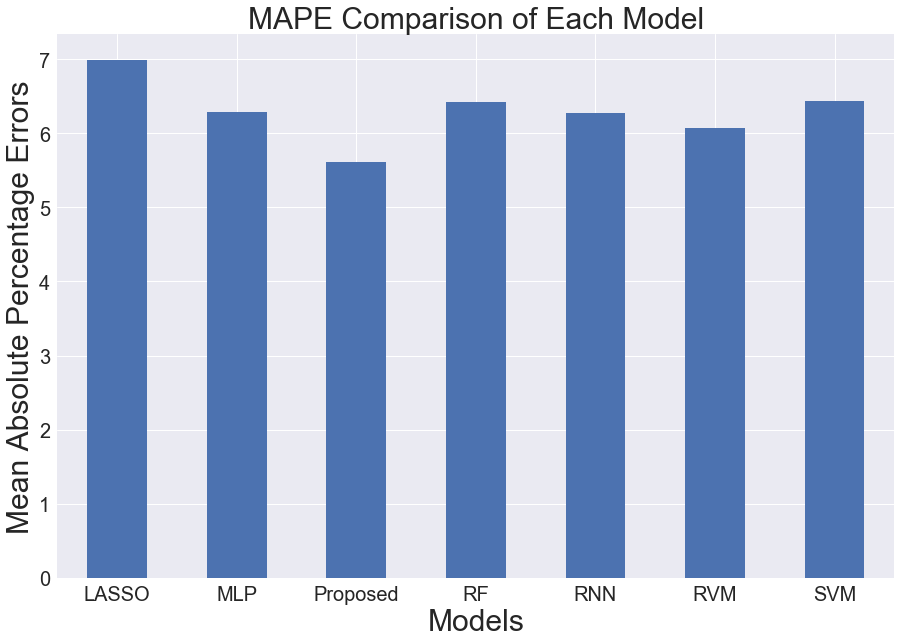

In [479]:
print(abcdef.mean())
my_plt = abcdef.mean().plot(kind='bar')
plt.xlabel("Models", {'fontsize':30})
plt.ylabel("Mean Absolute Percentage Errors",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("MAPE Comparison of Each Model", {'fontsize':30})
plt.savefig("plot_mean_mape.jpg", format='jpg', bbox_inches='tight', dpi=600)

       LASSO       MLP  Proposed        RF       RNN       RVM       SVM
1   6.817706  5.655565  4.635081  5.771443  5.499688  5.638769  6.919481
4   7.489871  6.308858  5.331235  6.238971  5.917941  5.496310  7.949667
8   6.313160  5.003628  4.009886  5.215585  4.541937  4.721738  5.092255
10  7.335233  6.860660  6.216494  7.106810  6.644375  6.942534  6.721778


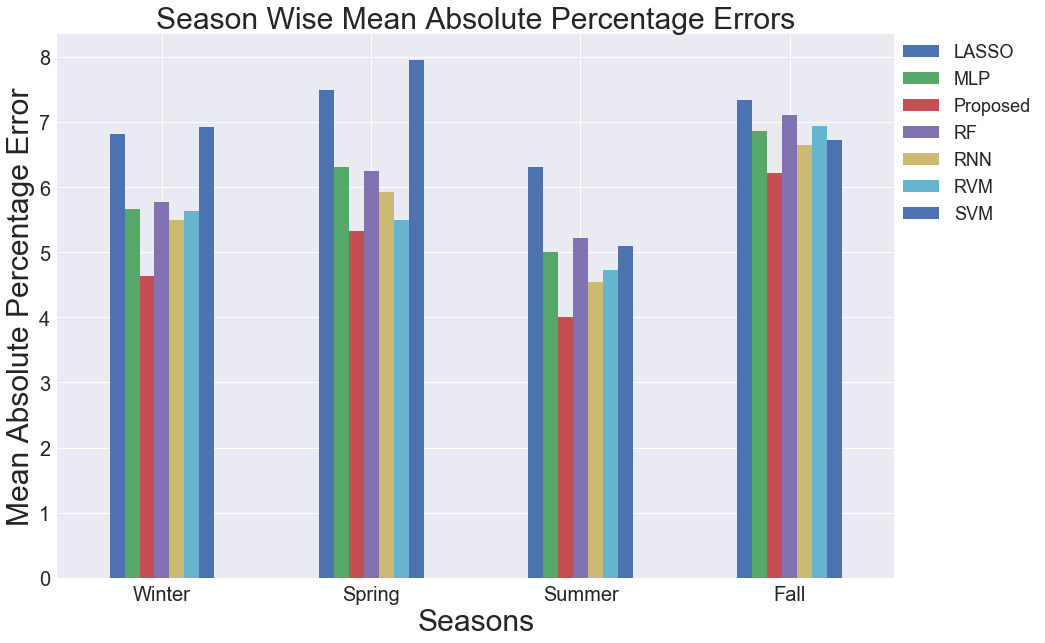

In [478]:
print(abcdef.iloc[[1,4,8,10]])
abc = abcdef.iloc[[1,4,8,10]].plot(kind='bar')
plt.xlabel("Seasons", {'fontsize':30})
plt.ylabel("Mean Absolute Percentage Error",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
abc.set_xticklabels(['Winter','Spring','Summer','Fall'])
plt.title("Season Wise Mean Absolute Percentage Errors", {'fontsize':30})
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1, fontsize=18)
plt.savefig("plot_season_mape.jpg", orientation='landscape', format='jpg', bbox_inches='tight', dpi=600)

### MAE

In [358]:
mae_df_final = pd.DataFrame({
    'RF': mae_list_rf,
    'RVM': mae_list2,
    'SVM': mae_list5,
    'MLP': mae_list4,
    'LASSO':mae_list6,
    'Proposed': mae_list,
    'RNN': mae_list7
})

LASSO       3.246411
MLP         3.034562
Proposed    2.695330
RF          3.116359
RNN         3.113197
RVM         2.924210
SVM         3.123838
dtype: float64


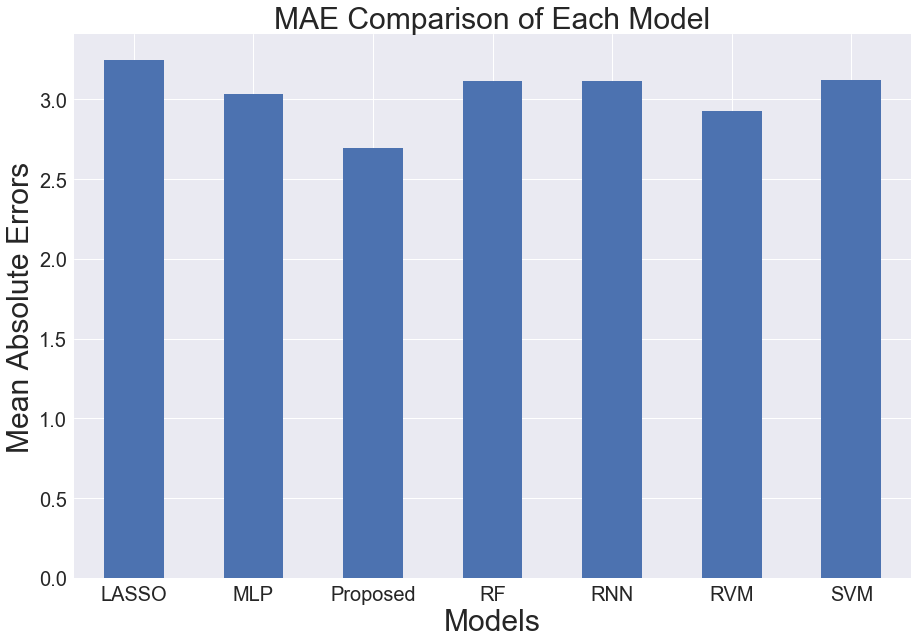

In [365]:
print(mae_df_final.mean())
my_plt = mae_df_final.mean().plot(kind='bar')
plt.xlabel("Models", {'fontsize':30})
plt.ylabel("Mean Absolute Errors",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("MAE Comparison of Each Model", {'fontsize':30})
plt.savefig("plot_mean_mae.jpg")

### RMSE

In [361]:
rmse_df_final = pd.DataFrame({
    'RF': rmse_list_rf,
    'RVM': rmse_list2,
    'SVM': rmse_list5,
    'MLP': rmse_list4,
    'LASSO':rmse_list6,
    'Proposed': rmse_list,
    'RNN': rmse_list7
})

LASSO       4.470762
MLP         4.209652
Proposed    3.782905
RF          4.445328
RNN         4.285134
RVM         4.056572
SVM         4.324708
dtype: float64


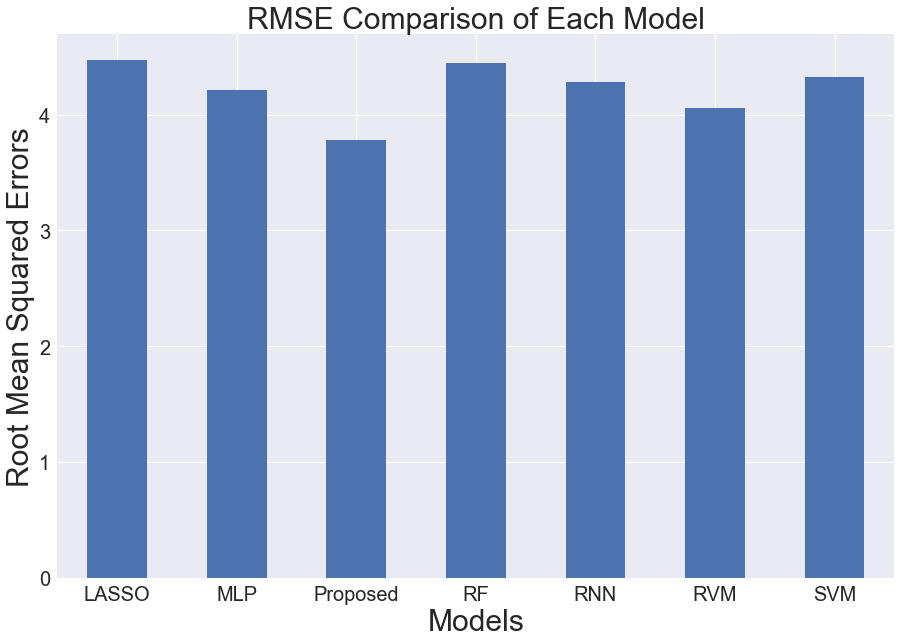

In [364]:
print(rmse_df_final.mean())
my_plt = rmse_df_final.mean().plot(kind='bar')
plt.xlabel("Models", {'fontsize':30})
plt.ylabel("Root Mean Squared Errors",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("RMSE Comparison of Each Model", {'fontsize':30})
plt.savefig("plot_mean_rmse.jpg")

### Plot Predicted Vs. Actual

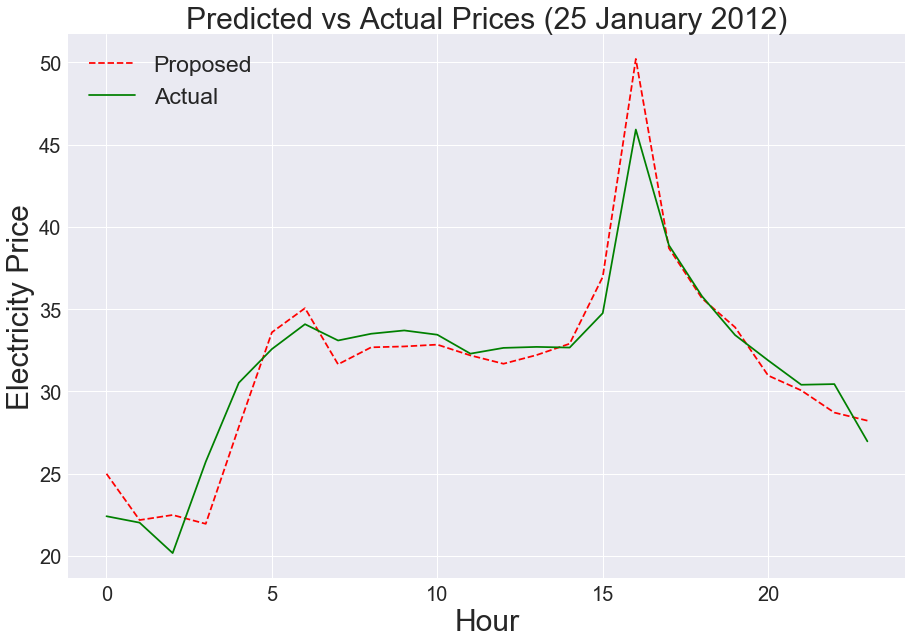

In [488]:
#import matplotlib.pyplot as plt
temp = pd.DataFrame({
    'Proposed':stacked_preds_price[0+24+24:0+24+24+24], 
    'Actual':test_y['TARGET_DA_LMP'][0+24+24:0+24+24+24]
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Proposed'], 'r--', label="Proposed")
plt.plot(temp['Actual'], 'g-', label="Actual")
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Electricity Price",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Prices (25 January 2012)", {'fontsize':30})
plt.legend(loc=2, fontsize=23)
plt.gcf()
plt.savefig("plot_single_day.jpg", format='jpg', bbox_inches='tight', dpi=600)

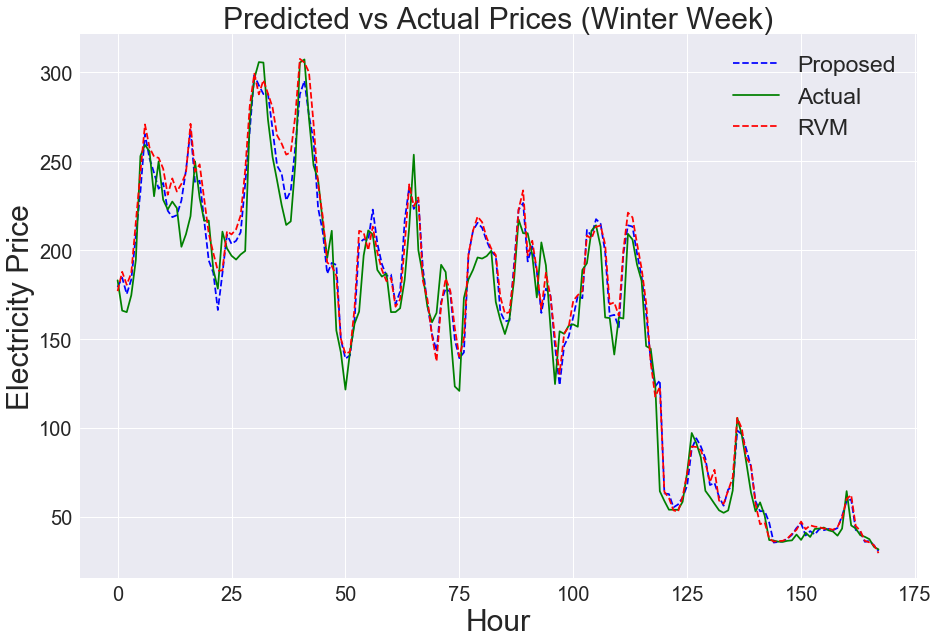

In [487]:
#import matplotlib.pyplot as plt
temp = pd.DataFrame({
    'Proposed':stacked_preds_price[2136:2136+168], 
    'Actual':test_y['TARGET_DA_LMP'][2136:2136+168],
    'RVM':rvm_pol_preds_price[2136:2136+168]
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Proposed'], 'b--', label="Proposed")
plt.plot(temp['Actual'], 'g-', label="Actual")
plt.plot(temp['RVM'], 'r--', label="RVM")
#temp.plot(kind='line')
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Electricity Price",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Prices (Winter Week)", {'fontsize':30})
plt.legend(loc=1, fontsize=23)
plt.gcf()
plt.savefig("plot_winter_week.jpg", format='jpg', bbox_inches='tight', dpi=600)